# <b> <font color='blue'> <center> Training Visualization </center> </font> </b>

## Setup

In [123]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import pandas as pd
from IPython.display import display
from datetime import datetime

## Helper Functions

In [124]:
# loads data for a specific model-data_variant
def load_data(index_path):
    # Load runs_index.json
    with open(index_path) as f:
        runs_index = json.load(f)
    
    # Sort by timestamp
    runs_index.sort(key=lambda x: x["timestamp"])
    
    # Base directory for JSON files
    base_dir = index_path.parent
    
    # Collect runs (no need to group by model_name)
    runs = []
    for run in runs_index:
        run_path = base_dir / run["json_file"]
        with open(run_path) as f:
            run_data = json.load(f)
        runs.append(run_data)

    return runs


In [125]:
# get basic info
def get_data(data):
    # Separate sections
    basic_info_keys = ['model_name', 'data_variant', 'timestamp']
    basic_info = {k: data[k] for k in basic_info_keys}
    hyperparams = data['hyperparameters']
    val_metrics = data.get('val_metrics', {})  # use .get in case it's missing
    
    # Convert to DataFrames
    df_basic = pd.DataFrame([basic_info])
    df_basic["timestamp_readable"] = df_basic["timestamp"].apply(
        lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    )
    
    df_hyper = pd.DataFrame([hyperparams])
    df_val = pd.DataFrame([val_metrics]) if val_metrics else pd.DataFrame()
    
    # Display nicely in notebook
    print("=== Basic Info ===")
    display(df_basic)
    
    print("=== Hyperparameters===")
    df_hyper_vertical = pd.DataFrame(list(hyperparams.items()), columns=['Parameter', 'Value'])
    display(df_hyper_vertical)
    

    print("=== Validation Metrics===")
    df_val_vertical = pd.DataFrame(list(val_metrics.items()), columns=['Metric', 'Value'])
    display(df_val_vertical)


In [126]:
# plots
def plot_history(history):
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='train_loss')#, marker='o')
    plt.plot(history['val_loss'], label='val_loss')#, marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='train_acc')#, marker='o')
    plt.plot(history['val_accuracy'], label='val_acc')#, marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


## Models

### Baseline

#### Simple data

In [127]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,simple,20250819_204000,2025-08-19 20:40:00


=== Hyperparameters===


,Parameter,Value
0,batch_size,64
1,optimizer,adam
2,learning_rate,0.001
3,epochs,2


=== Validation Metrics===


,Metric,Value
0,loss,4.857864
1,accuracy,0.245614
2,precision,0.270833
3,recall,0.619048
4,f1,0.376812


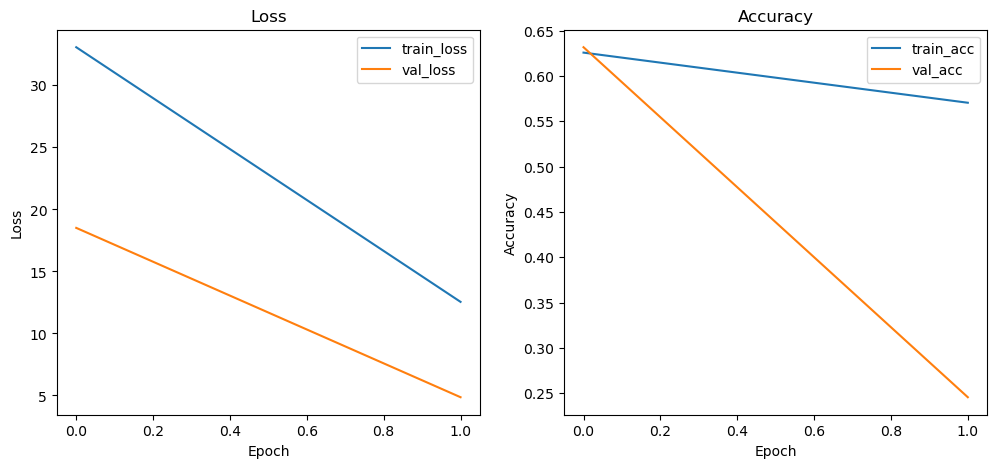

In [128]:
index_path = Path("../logs/training/baseline/simple/runs_index.json")
baseline_models = load_data(index_path)



for b in baseline_models:

    get_data(b)

    history = b['history']
    plot_history(history)

#### Standardize data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,standardize,20250819_202834,2025-08-19 20:28:34


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,optimizer,adam
2,learning_rate,0.001
3,epochs,2


=== Validation Metrics===


,Metric,Value
0,loss,0.373014
1,accuracy,0.912281
2,precision,0.807692
3,recall,1.000000
4,f1,0.893617


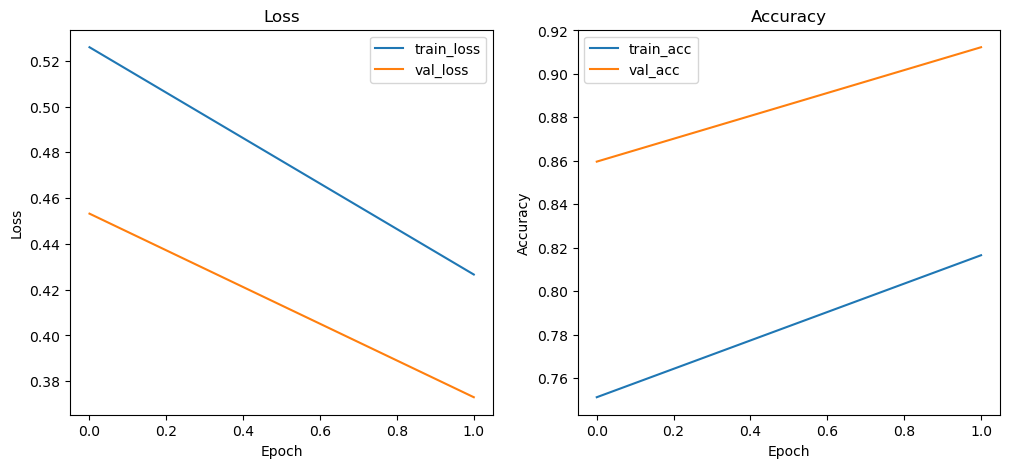

In [122]:
index_path = Path("../logs/training/baseline/standardize/runs_index.json")
baseline_models = load_data(index_path)

get_data(baseline_models[1])

history = baseline_models[1]['history']
plot_history(history)